In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import networkx as nx
from tqdm import tqdm
import seaborn as sns

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)
sns.set_theme()

In [2]:
years = 5
date_to = "07.06.2023"

imoex_shares_path = "../data/tickers_info/imoex_shares.csv"
imoex_index_shares_path = "../data/tickers_info/imoex_index_shares.csv"
daily_data_folder = f"../data/historical/daily_data_for_{years}_years_till_{datetime.strptime(date_to, '%d.%m.%Y').strftime('%Y-%m-%d')}/"

def daily_data_fname(ticker, uid):
    return f"{ticker}_{uid}.csv"

In [3]:
shares_info = pd.read_csv(imoex_shares_path) # interchangable with imoex_index_shares_path
print(shares_info.shape)
shares_info.head(5)

(139, 4)


,figi,ticker,name,uid
0,BBG000BN56Q9,DSKY,Детский Мир,6e061639-6198-4448-9568-1eadb1b0e127
1,BBG000RMWQD4,ENPG,En+ Group,e2bd2eba-75de-4127-b39c-2f2dbe3866c3
2,BBG004PYF2N3,POLY,Polymetal,127361c2-32ec-448c-b3ec-602166f537ea
3,BBG000GQSVC2,NKNCP,Нижнекамскнефтехим - акции привилегированные,bc21fb4f-8838-4355-8697-fb0d8fc809c8
4,BBG000FWGSZ5,IRKT,Корпорация ИРКУТ,cfb50a23-2465-497e-bc7e-e4f0e042cf3d


In [4]:
# Count share returns

# "fill" - fill with 0
# "cut"  - cut to maximum start date
act_w_missing_starts = "fill"

# If the stock started trading after this date - remove it
max_first_date_to_exist = datetime.strptime(date_to, '%d.%m.%Y') - timedelta(days=365 * years - 250)

common_df, date_start = None, None
for idx, info in shares_info.iterrows():
    cur_df = pd.read_csv(daily_data_folder + daily_data_fname(info["ticker"], info["uid"]), index_col=0)
    cur_df.index = pd.to_datetime(cur_df.index)
    # From the book
    cur_df = pd.DataFrame(np.log(cur_df["close"] / cur_df["open"]), columns=[info["ticker"]])
    # Diff percentage
    # cur_df = pd.DataFrame((cur_df["close"] - cur_df["open"]) / cur_df["open"], columns=[info["ticker"]])
    cur_min_date = cur_df.index.min()
    print(f"{info['name']}\t first candle date is: {cur_min_date}")
    if max_first_date_to_exist is not None and cur_min_date > max_first_date_to_exist:
        print(f"Stock {info['ticker']} started trading too late for research")
        continue
    if common_df is None:
        common_df = cur_df
        date_start = cur_min_date
    else:
        common_df = common_df.join(cur_df, how="outer")
        if date_start < cur_min_date:
            date_start = cur_min_date
if act_w_missing_starts == "fill":
    print(f"Min date is: {common_df.index.min()}")
elif act_w_missing_starts == "cut":
    common_df = common_df.loc[common_df.index >= date_start]
    print(f"Min date is: {date_start}")
else:
    raise RuntimeError("Unknown missing starts action")
common_df = common_df.fillna(0).sort_index().copy()
common_df

Детский Мир	 first candle date is: 2018-06-08 00:00:00
En+ Group	 first candle date is: 2020-02-20 00:00:00
Stock ENPG started trading too late for research
Polymetal	 first candle date is: 2018-06-08 00:00:00
Нижнекамскнефтехим - акции привилегированные	 first candle date is: 2018-06-08 00:00:00
Корпорация ИРКУТ	 first candle date is: 2018-06-08 00:00:00
МРСК Волги	 first candle date is: 2018-06-08 00:00:00
ВСМПО-АВИСМА	 first candle date is: 2018-06-08 00:00:00
Объединенная авиастроительная корпорация	 first candle date is: 2018-06-08 00:00:00
Группа ЛСР	 first candle date is: 2018-06-08 00:00:00
Таттелеком	 first candle date is: 2018-06-08 00:00:00
Центральный Телеграф	 first candle date is: 2018-06-08 00:00:00
Магнит	 first candle date is: 2018-06-08 00:00:00
СОЛЛЕРС	 first candle date is: 2018-06-08 00:00:00
Etalon Group PLC ГДР	 first candle date is: 2020-02-03 00:00:00
Stock ETLN started trading too late for research
Ростелеком - Привилегированные акции	 first candle date is: 20

,DSKY,POLY,NKNCP,IRKT,MRKV,VSMO,UNAC,LSRG,TTLK,CNTL,...,CNTLP,PIKK,ROSN,MTLRP,TRMK,MRKU,MRKY,KRKNP,CHMF,ISKJ
2018-06-08,0.0011,-0.0117,-0.0082,0.0000,-0.0071,-0.0071,0.0000,-0.0176,0.0145,-0.0366,...,-0.0777,0.0000,-0.0012,-0.0144,0.0006,-0.0134,-0.0247,-0.0429,-0.0180,0.0000
2018-06-09,0.0085,0.0029,0.0229,-0.0290,-0.0004,-0.0083,0.0141,0.0064,0.0000,0.0000,...,0.0127,-0.0021,0.0012,-0.0007,0.0012,-0.0268,0.0000,-0.0018,0.0049,-0.0163
2018-06-11,-0.0011,0.0084,-0.0016,-0.0117,0.0248,-0.0119,0.0063,0.0076,0.0059,0.0189,...,-0.0125,-0.0006,0.0046,0.0066,-0.0175,-0.0024,0.0077,0.0009,0.0167,0.0000
2018-06-13,-0.0021,-0.0030,0.0065,0.0059,-0.0081,0.0024,0.0188,-0.0082,-0.0087,0.0000,...,-0.0418,-0.0012,-0.0089,-0.0125,-0.0098,0.0025,0.0000,-0.0053,-0.0019,0.0000
2018-06-14,-0.0032,-0.0050,-0.0016,-0.0178,-0.0199,-0.0024,0.0047,-0.0030,0.0087,0.0497,...,0.0253,0.0000,-0.0055,-0.0015,0.0025,-0.0251,0.0046,-0.0044,-0.0156,-0.0377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-03,0.0000,-0.0084,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0052,0.0115,-0.0064,0.0024,0.0000,0.0000,0.0000,0.0039,0.0000
2023-06-04,0.0000,0.0052,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0063,0.0004,-0.0026,-0.0010,0.0000,0.0000,0.0000,-0.0037,0.0000
2023-06-05,-0.0028,-0.0394,0.0138,-0.0209,-0.0146,-0.0134,-0.0063,-0.0091,-0.0152,0.0040,...,-0.0031,-0.0028,-0.0171,-0.0313,-0.0483,-0.0477,-0.0339,0.0077,-0.0093,-0.0050
2023-06-06,0.0022,-0.0052,-0.0087,-0.0110,-0.0049,-0.0094,-0.0106,0.0146,-0.0162,-0.0175,...,-0.0094,0.0025,0.0103,0.0456,0.0347,0.0133,-0.0041,-0.0093,-0.0078,-0.0133


In [5]:
# Number of days missing

(common_df.head(500) == 0).sum().sort_values(ascending=False).head(50)

VRSB     205
ABRD     168
GTRK     148
KAZTP    138
UNKL     132
TGKN     119
YAKG     112
KAZT      99
AQUA      92
CNTL      79
LSNG      73
BELU      66
KLSB      66
NSVZ      60
NKHP      60
TGKBP     59
LSNGP     52
RKKE      50
PMSB      46
NKNC      40
VSMO      39
LNZL      37
PMSBP     36
ISKJ      35
KZOS      35
LNZLP     34
KROT      34
GCHE      34
CNTLP     33
TTLK      33
SELG      32
SVAV      32
KRKNP     31
RUGR      29
TGKB      28
AKRN      28
LIFE      28
BLNG      26
CHMK      25
AMEZ      25
MSRS      24
FESH      24
KMAZ      23
RTKMP     22
KZOSP     22
MRKS      21
MRKU      19
MSTT      19
MGTSP     19
APTK      18
dtype: int64

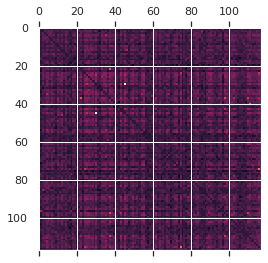

In [6]:
common_edges = common_df.head(500).corr(method="kendall").values
np.fill_diagonal(common_edges, 0)
plt.matshow(common_edges)

In [7]:
date_min = common_df.index.min()
date_max = common_df.index.max()
print(f"We have data from {date_min.date()} to {date_max.date()} inclusive")

We have data from 2018-06-08 to 2023-06-07 inclusive


In [8]:
common_df.index[500]

Timestamp('2020-06-02 00:00:00')

In [223]:
# Choosing periods for market graphs. Let's take it monthly, yearly and overall. First inclusive, second exclusive

periods = []

# # Overall period
# periods.append((date_min, date_max + timedelta(days=1)))

# 500 traded-days peroids, 50-days shift
period = 200
shift = 50
cur_idx = 0
while common_df[cur_idx: cur_idx + period].shape[0] == period:
    periods.append((common_df.index[cur_idx], common_df.index[cur_idx + period]))
    cur_idx += shift

# # Yearly periods
# period = timedelta(days=365)
# d_start_tmp = date_min
# while d_start_tmp + period < date_max:
#     periods.append((d_start_tmp, d_start_tmp + period))
#     d_start_tmp += period
# if d_start_tmp + period - date_max < timedelta(days=10):
#     periods.append((d_start_tmp, date_max + timedelta(days=1)))

# # Monthly periods
# period = timedelta(days=30)
# d_start_tmp = date_min
# while d_start_tmp + period < date_max:
#     periods.append((d_start_tmp, d_start_tmp + period))
#     d_start_tmp += period
# if d_start_tmp + period - date_max < timedelta(days=10):
#     periods.append((d_start_tmp, date_max + timedelta(days=1)))

print(len(periods))
periods

24


[(Timestamp('2018-06-08 00:00:00'), Timestamp('2019-03-22 00:00:00')),
 (Timestamp('2018-08-17 00:00:00'), Timestamp('2019-06-04 00:00:00')),
 (Timestamp('2018-10-26 00:00:00'), Timestamp('2019-08-14 00:00:00')),
 (Timestamp('2019-01-10 00:00:00'), Timestamp('2019-10-23 00:00:00')),
 (Timestamp('2019-03-22 00:00:00'), Timestamp('2020-01-08 00:00:00')),
 (Timestamp('2019-06-04 00:00:00'), Timestamp('2020-03-20 00:00:00')),
 (Timestamp('2019-08-14 00:00:00'), Timestamp('2020-06-02 00:00:00')),
 (Timestamp('2019-10-23 00:00:00'), Timestamp('2020-08-14 00:00:00')),
 (Timestamp('2020-01-08 00:00:00'), Timestamp('2020-10-23 00:00:00')),
 (Timestamp('2020-03-20 00:00:00'), Timestamp('2021-01-06 00:00:00')),
 (Timestamp('2020-06-02 00:00:00'), Timestamp('2021-03-19 00:00:00')),
 (Timestamp('2020-08-14 00:00:00'), Timestamp('2021-05-31 00:00:00')),
 (Timestamp('2020-10-23 00:00:00'), Timestamp('2021-08-09 00:00:00')),
 (Timestamp('2021-01-06 00:00:00'), Timestamp('2021-10-18 00:00:00')),
 (Time

In [225]:
# Build threshold graphs + find max cliques

thresholds_range = [("pearson", 0.2 + 0.1*i) for i in range(8)] + [("kendall", 0.1 + 0.05*i) for i in range(12)]

data = []
pbar = tqdm(total=len(periods) * len(thresholds_range))
for period in periods:
    # Calculating Kendall correlation
    sub_df = common_df.loc[(period[0] <= common_df.index) & (common_df.index < period[1])]
    vertices = sub_df.columns
    edges_p = np.abs(sub_df.corr(method="pearson"))
    edges_k = np.abs(sub_df.corr(method="kendall"))
    np.fill_diagonal(edges_p.values, 0)
    np.fill_diagonal(edges_k.values, 0)
    data.append((period, {}))

    for method, threshold in thresholds_range:
        if method == "pearson":
            edges = edges_p
        elif method == "kendall":
            edges = edges_k
        else:
            raise RuntimeError("Unknown correlation method")
        cur_data_name = f"{method}_{threshold:.2f}"
        data[-1][1][cur_data_name] = {}

        # Building a threshold market graph
        G = nx.Graph()
        G.add_nodes_from(vertices)
        for i in range(edges.shape[0]):
            for j in range(i+1, edges.shape[0]):
                if edges.values[i, j] > threshold:
                    G.add_edge(vertices[i], vertices[j])
        data[-1][1][cur_data_name]["graph"] = G
        
        # Finding maximum cliques
        max_cliques_arr = []
        max_cliques_size = 0
        for clique in nx.clique.find_cliques(G):
            if len(clique) > max_cliques_size:
                max_cliques_size = len(clique)
                max_cliques_arr = [sorted(clique)]
            elif len(clique) == max_cliques_size:
                max_cliques_arr.append(sorted(clique))
        data[-1][1][cur_data_name]["max_clique_size"] = max_cliques_size
        data[-1][1][cur_data_name]["max_cliques_number"] = len(max_cliques_arr)

        # Union of max cliques w/ contribution
        shares_appearance_perc = {}
        one_stock_contrib = max_cliques_size * len(max_cliques_arr)
        for max_cl in max_cliques_arr:
            for share in max_cl:
                if share in shares_appearance_perc:
                    shares_appearance_perc[share] += 1 / one_stock_contrib
                else:
                    shares_appearance_perc[share] = 1 / one_stock_contrib
        data[-1][1][cur_data_name]["shares_appearance_perc"] = shares_appearance_perc
        pbar.update(1)

 99%|█████████▉| 477/480 [01:49<00:00,  4.75it/s]

In [226]:
def plot_area_chart(data, data_name, contrib_threshold=0.1):
    common_df = None
    for period, info in data:
        cur_df = pd.DataFrame.from_dict(info[data_name]["shares_appearance_perc"], orient="index", columns=[period[0]])
        if common_df is None:
            common_df = cur_df
        else:
            common_df = common_df.join(cur_df, how="outer")
    common_df = common_df.fillna(0).sort_index()

    # Sum small values and drop empty columns
    other_sum = common_df[common_df < contrib_threshold].sum().rename("Smaller contribs")
    common_df[common_df < contrib_threshold] = 0
    common_df = common_df.append(other_sum)
    common_df = common_df.loc[(common_df > 0).any(axis=1)].copy()

    # Sort by summary area
    common_df["sum"] = common_df.sum(axis=1)
    common_df.sort_values(by="sum", ascending=False, inplace=True)
    common_df.drop(columns="sum", inplace=True)

    
    ax = plt.stackplot(common_df.columns,
                   [row for _, row in common_df.iterrows()],
                   labels=common_df.index)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.xlabel("Period start")
    plt.xticks(rotation=30)
    plt.ylabel("Share contribution percent")
    return common_df

/tmp/ipykernel_4671/2619476874.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  common_df = common_df.append(other_sum)


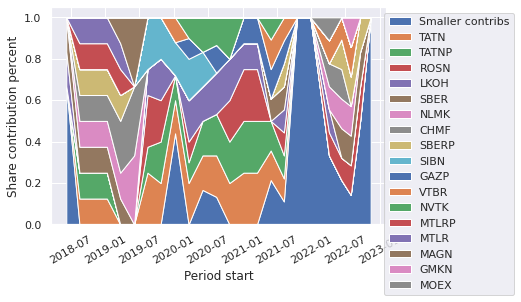

In [237]:
cdf = plot_area_chart(data, "kendall_0.35", 0.1)

In [48]:
nx.draw(G.subgraph(stock_appearance_perc.keys()), with_labels=True)

NameError: name 'stock_appearance_perc' is not defined

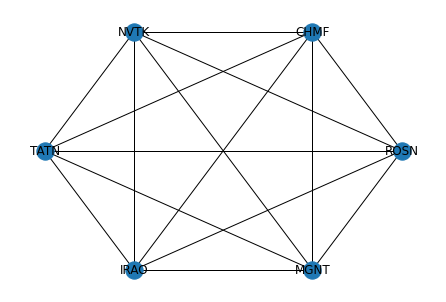

In [62]:
nx.draw_circular(G.subgraph(nx.approximation.max_clique(G)), with_labels=True)

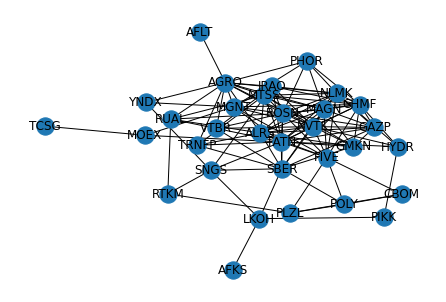

In [60]:
for i, component in enumerate(nx.connected_components(G)):
    nx.draw_kamada_kawai(G.subgraph(component), with_labels=True)
    plt.pause(0.05)
    if i == 10:
        break